In [1]:
import pandas as pd
import numpy as np

import os

from nltk.tokenize import sent_tokenize, word_tokenize

import re



import random

## Deep Learning imports for the classifiers
os.environ['KERAS_BACKEND']='theano'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Concatenate
from keras.models import Model

##Â ML required imports (for clustering)
from sklearn import metrics
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.preprocessing import scale, StandardScaler
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer



# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set() 

Using Theano backend.


In [2]:
FLAG__AGGREGATE_CONVENTIONS_SENTENCES_FROM_GITHUB = False
FLAG__GENERATE_SENTECE_TOKENIZED_DOCS=False

In [3]:
## Deep Learning models config

## Classificaiton NETWORKs Configuration parameters
MAX_SEQUENCE_LENGTH = 32
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 100 ## 100, 200 or 300
VALIDATION_SPLIT = 0.2

NUM_EPOCHS = 20

In [4]:
## Reading GLOVE (precalculated word embeddings)
GLOVE_DIR = ""
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.{}d.txt'.format(EMBEDDING_DIM)))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [5]:
BASE_DIR = "./DATA/VALIDATED_DATA/Conventions/Justifications/"
BASE_DIR2 = "./DATA/VALIDATED_DATA/Conventions/"

In [32]:
justif_files = [f for f in os.listdir(BASE_DIR) if (os.path.isfile(os.path.join(BASE_DIR, f)) and not f.startswith( '.' ) and not "random" in f and not "training_" in f and not "aggregated_" in f and not "splitted_" in f)]
justif_files

['Industrial.txt',
 'Civic.txt',
 'Domestic.txt',
 'Market.txt',
 'Renown.txt',
 'Project.txt',
 'Green.txt',
 'Inspired.txt']

In [33]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    text = text.replace("b'", "")
    
    ## Removing strings such as \\xe5 \\xe6 \\xe7 that appear a lot in the descriptions
    text = re.sub(r':?\\+x\w{2}', ' ', text, flags=re.MULTILINE)
    
    return text

In [ ]:
if FLAG__GENERATE_SENTECE_TOKENIZED_DOCS:
    for x in justif_files:
        with open(os.path.join(BASE_DIR, x), 'rb') as f:
            texts = []
            data = str(f.read())

            for s in sent_tokenize(data):
                texts.append(pre_process(s))
        f.close()

        with open(os.path.join(BASE_DIR, "splitted_"+x), 'w') as f2:
            for t in texts:
                f2.write(t+"\n")

            f2.close()

In [35]:
conv_files = [f for f in os.listdir(BASE_DIR2) if (os.path.isfile(os.path.join(BASE_DIR2, f)) and not f.startswith( '.' ) and not "random" in f and not "training_" in f)]
conv_files

['Industrial.txt',
 'Civic.txt',
 'Domestic.txt',
 'Market.txt',
 'Renown.txt',
 'Project.txt',
 'Green.txt',
 'Inspired.txt']

## Agregate justifications with already existing conventions sentences

In [36]:
if FLAG__AGGREGATE_CONVENTIONS_SENTENCES_FROM_GITHUB:
    for i,x in enumerate(justif_files):
        texts = []
        with open(os.path.join(BASE_DIR, x), 'rb') as f:
            data = str(f.read())

            docs.append(pre_process(data))

            for s in sent_tokenize(data):
                texts.append(pre_process(s))
            f.close()    
        with open(os.path.join(BASE_DIR2, x), 'rb') as f2:
            data2 = str(f2.read())

            docs.append(pre_process(data2))

            for s in sent_tokenize(data2):
                texts.append(pre_process(s))
            f2.close()  

        with open(os.path.join(BASE_DIR, 'aggregated_{}'.format(x)), 'w') as f3: 
            for t in texts:

                f.write(t.replace("\\n", "")+ '\n')
            f3.close()


In [37]:
if FLAG__AGGREGATE_CONVENTIONS_SENTENCES_FROM_GITHUB:
    justif_files = [f for f in os.listdir(BASE_DIR) if (os.path.isfile(os.path.join(BASE_DIR, f)) and not f.startswith( '.' ) and not "random" in f and not "training_" in f and "aggregated_" in f)]
    justif_files

In [38]:
texts = []
convs = []
docs = []

for x in justif_files:
    with open(os.path.join(BASE_DIR, x), 'rb') as f:
        data = str(f.read())
        
        docs.append(pre_process(data))
        
        for s in data.split("."):
            texts.append(pre_process(s))
            convs.append(x.replace(".txt", ""))
        

In [39]:
df = pd.DataFrame(columns=['text', 'convention'])
df['text'] = texts
df['convention'] = convs
df.head()

,text,convention
0,justifications based on technical efficiency a...,Industrial
1,this category relates to the industrial ...,Industrial
2,while technical competency and planning argum...,Industrial
3,market justifications place value based on th...,Industrial
4,"in addition, the form of proof involved in ma...",Industrial


In [40]:
document_lengths = np.array(list(map(len, df.text.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 29.222605099931084.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 131.


## TFIDF

In [41]:
cv=CountVectorizer(max_df=0.85,max_features=10000)
word_count_vector=cv.fit_transform(docs)

In [42]:
list(cv.vocabulary_.keys())[:10]

['technical',
 'efficiency',
 'planning',
 'nanother',
 'category',
 'includes',
 'evaluations',
 'depend',
 'professionalism',
 'longterm']

In [43]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [44]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
 
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
 

In [45]:
# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names()

for i,f in enumerate(justif_files):

    # get the document that we want to extract keywords from
    
    doc = docs[i]
    #generate tf-idf for the given document
    tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(feature_names,sorted_items,15)

    # now print the results
    print("\n=====Doc=====")
    print(f)
    print("\n===Keywords===")
    for k in keywords:
        print(k,keywords[k])


=====Doc=====
Industrial.txt

===Keywords===
planning 0.283
efficiency 0.19
future 0.166
technical 0.163
production 0.163
economic 0.157
temporal 0.119
function 0.105
dam 0.105
action 0.105
term 0.103
organization 0.095
space 0.095
functioning 0.094
functional 0.094

=====Doc=====
Civic.txt

===Keywords===
collective 0.395
civic 0.298
interests 0.197
solidarity 0.194
union 0.151
workers 0.15
representative 0.139
chapter 0.132
equality 0.13
delegates 0.125
civil 0.125
citizens 0.116
representatives 0.11
legal 0.109
delegate 0.097

=====Doc=====
Domestic.txt

===Keywords===
whom 0.198
children 0.174
superiors 0.173
upbringing 0.156
household 0.139
behavior 0.125
backyard 0.121
tradition 0.121
family 0.11
manners 0.104
inferiors 0.104
heritage 0.102
superior 0.1
land 0.099
brought 0.099

=====Doc=====
Market.txt

===Keywords===
goods 0.265
business 0.219
competition 0.204
desires 0.19
wealth 0.139
coordination 0.131
price 0.127
economic 0.117
convention 0.117
object 0.113
desire 0.107
tr

## Training models on justification text

In [46]:
def rreplace(s, old, new, occurrence):
    li = s.rsplit(old, occurrence)
    return new.join(li)

In [47]:
## This code generates a training file for each characteristic by 
## concetanting sentences for convention X annotated with label one 
## and sentences from all the other convention that are annotated with label 0.

##It generates a training_{convention_name}.csv file for each convention
def generate_training_files(data_dir, data_files):
    for file_name in data_files:

        f = open(os.path.join(data_dir,file_name), "r")
        original_lines = f.readlines()
        
        original_lines2=[]
        for l in original_lines:
                for l2 in l.split("."):
                    original_lines2.append(l2)
        f.close()


        """
        Step 1: Generate four random numbers between 0 and 1
        Step 2: Add these four numbers
        Step 3: Divide each of the four numbers by the sum,
        Step 4: Multiply by 100, and round to the nearest integer.
        """
        num_original_lines = len(original_lines2)*2

        num_random_lines = np.random.uniform(0,1,len(data_files))
        num_random_lines = (num_random_lines / sum(num_random_lines))*num_original_lines

        tmp_all_files = [f for f in data_files if f != file_name]

        random_lines = []    
        for idx, file_name2 in enumerate(tmp_all_files):
            f2 = open(os.path.join(data_dir,file_name2), "r")
            tmp_lines = f2.readlines()
            
            tmp_lines2 = []
            for l in tmp_lines:
                for l2 in l.split("."):
                    tmp_lines2.append(l2)
            f2.close()

            for i in range(int(num_random_lines[idx])):
                random_lines.append(random.choice(tmp_lines2))

        with open(rreplace(os.path.join(data_dir,file_name), "/", "/training_",1), "w") as f3:
            f3.write("{}\t{}\n".format("category", "text"))

            for idx, l in enumerate(original_lines2):
                l = l.replace('\n', ' ').replace('\t', ' ')
                f3.write("{}\t\"{}\"\n".format(1, l))


            for idx, l2 in enumerate(random_lines):
                l2 = l2.replace('\n', '').replace('\t', ' ')
                f3.write("{}\t\"{}\"\n".format(0, l2))
            f3.close()

In [48]:
generate_training_files(BASE_DIR, justif_files)

In [55]:
if FLAG__AGGREGATE_CONVENTIONS_SENTENCES_FROM_GITHUB:
    justif_training_files = [f for f in os.listdir(BASE_DIR) if (os.path.isfile(os.path.join(BASE_DIR, f)) and not f.startswith( '.' ) and not "random" in f and "training_aggregated" in f and not "splitted_" in f)]
    print(justif_training_files)
else:
    justif_training_files = [f for f in os.listdir(BASE_DIR) if (os.path.isfile(os.path.join(BASE_DIR, f)) and not f.startswith( '.' ) and not "random" in f and not "training_aggregated" in f and "training_" in f and not "splitted_" in f)]
    print(justif_training_files)

['training_Domestic.txt', 'training_Civic.txt', 'training_Project.txt', 'training_Inspired.txt', 'training_Green.txt', 'training_Market.txt', 'training_Industrial.txt', 'training_Renown.txt']


In [56]:
def create_tokenizer(DATA_DIR, data_files, max_words=MAX_NB_WORDS):
    texts = []
    for d in data_files:
        data_train = pd.read_csv(os.path.join(DATA_DIR,d), sep='\t')
    
        for idx in range(data_train.text.shape[0]):
            text = data_train.text[idx]
            texts.append(str(text))
    
    _tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    _tokenizer.fit_on_texts(texts)
    
    return _tokenizer 
    

In [57]:
conventions_tokenizer = create_tokenizer(BASE_DIR, justif_training_files)

In [58]:
def read_file_and_train_model(DATA_DIR, data_file, tokenizer=None, num_epochs=NUM_EPOCHS):
    ## USING licensing text from github
    data_train = pd.read_csv(os.path.join(DATA_DIR,data_file), sep='\t')
    print(data_train.shape)

    data_train = data_train

    texts = []
    labels = []

    for idx in range(data_train.text.shape[0]):
        text = data_train.text[idx]#BeautifulSoup(data_train.text[idx])
        texts.append(str(text))#clean_str(text))

        labels.append(data_train.category[idx])
        
    if tokenizer is None:
        tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
        tokenizer.fit_on_texts(texts)
        sequences = tokenizer.texts_to_sequences(texts)
    else:
        print(" -- Tokenizer has not been retrained")


    sequences = tokenizer.texts_to_sequences(texts)
    #embeddings_index = {}

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

    labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

    x_train = data[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = data[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]

    
    print('\nNumber of elements from each class in traing and validation set ')
    print(y_train.sum(axis=0))
    print(y_val.sum(axis=0))
    
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)

    """
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    l_pool2 = MaxPooling1D(5)(l_cov2)
    #l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
    #l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    print("model fitting - simplified convolutional neural network")
    model.summary()
    train_history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=num_epochs, batch_size=128)
    """
    # applying a more complex convolutional approach
    convs = []
    filter_sizes = [3,4,5]

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    for fsz in filter_sizes:
        l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)#Merge(mode='concat', concat_axis=1)(convs)
    l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    #l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
    #l_pool2 = MaxPooling1D(30)(l_cov2)
    #l_flat = Flatten()(l_pool2)
    l_flat = Flatten()(l_pool1)
    l_dense = Dense(128, activation='relu')(l_flat)
    preds = Dense(2, activation='softmax')(l_dense)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])

    print("model fitting - more complex convolutional neural network")
    model.summary()
    train_history = model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=num_epochs, batch_size=50)
    
    return model,tokenizer,x_val,y_val, train_history

In [101]:
_conventions_models = {}
_conventions_tokenizers = {}
_conventions_data_val_x = {}
_conventions_data_val_y = {}
_conventions_train_histories = {}

for f in justif_training_files:


    print("----------------------------------------------------------------")
    print("            {}                  ".format(f))
    print("----------------------------------------------------------------")

    _model, _tokenizer, _x_val, _y_val, _train_h = read_file_and_train_model(BASE_DIR, f, tokenizer=conventions_tokenizer)


    _conventions_models[f] = _model
    _conventions_tokenizers[f] = _tokenizer
    _conventions_data_val_x[f] = _x_val
    _conventions_data_val_y[f] = _y_val
    _conventions_train_histories[f] = _train_h

    print("\n\n\n")

----------------------------------------------------------------
            training_Domestic.txt                  
----------------------------------------------------------------
(860, 2)
 -- Tokenizer has not been retrained
Found 5865 unique tokens.
Shape of data tensor: (860, 32)
Shape of label tensor: (860, 2)

Number of elements from each class in traing and validation set 
[445. 243.]
[117.  55.]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`


model fitting - more complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, 32, 100)      586600      input_45[0][0]                   
__________________________________________________________________________________________________
conv1d_177 (Conv1D)             (None, 30, 128)      38528       embedding_45[0][0]               
__________________________________________________________________________________________________
conv1d_178 (Conv1D)             (None, 29, 128)      51328       embedding_45[0][0]               
___________________________________________________

dense_92 (Dense)                (None, 2)            258         dense_91[0][0]                   
Total params: 855,786
Trainable params: 269,186
Non-trainable params: 586,600
__________________________________________________________________________________________________
Train on 497 samples, validate on 124 samples
Epoch 1/20
497/497 [==============================] - 1s 2ms/step - loss: 0.8855 - acc: 0.5775 - val_loss: 0.6409 - val_acc: 0.6532
Epoch 2/20
497/497 [==============================] - 1s 2ms/step - loss: 0.6336 - acc: 0.6640 - val_loss: 0.6149 - val_acc: 0.6532
Epoch 3/20
497/497 [==============================] - 1s 2ms/step - loss: 0.6134 - acc: 0.6499 - val_loss: 0.6545 - val_acc: 0.6532
Epoch 4/20
497/497 [==============================] - 1s 2ms/step - loss: 0.5511 - acc: 0.6962 - val_loss: 0.6382 - val_acc: 0.6694
Epoch 5/20
497/497 [==============================] - 1s 2ms/step - loss: 0.5041 - acc: 0.8149 - val_loss: 0.5315 - val_acc: 0.7258
Epoch 6/20
497/497

Epoch 10/20
722/722 [==============================] - 2s 2ms/step - loss: 0.1592 - acc: 0.9321 - val_loss: 0.3715 - val_acc: 0.8167
Epoch 11/20
722/722 [==============================] - 2s 2ms/step - loss: 0.0643 - acc: 0.9778 - val_loss: 0.4015 - val_acc: 0.8056
Epoch 12/20
722/722 [==============================] - 2s 2ms/step - loss: 0.0552 - acc: 0.9778 - val_loss: 0.5883 - val_acc: 0.7667
Epoch 13/20
722/722 [==============================] - 2s 2ms/step - loss: 0.0466 - acc: 0.9834 - val_loss: 0.4409 - val_acc: 0.8333
Epoch 14/20
722/722 [==============================] - 2s 2ms/step - loss: 0.0443 - acc: 0.9834 - val_loss: 0.7788 - val_acc: 0.7444
Epoch 15/20
722/722 [==============================] - 2s 2ms/step - loss: 0.2255 - acc: 0.9307 - val_loss: 0.4345 - val_acc: 0.8111
Epoch 16/20
722/722 [==============================] - 2s 2ms/step - loss: 0.0470 - acc: 0.9792 - val_loss: 0.4438 - val_acc: 0.8056
Epoch 17/20
722/722 [==============================] - 2s 2ms/step - 

(305, 2)
 -- Tokenizer has not been retrained
Found 5865 unique tokens.
Shape of data tensor: (305, 32)
Shape of label tensor: (305, 2)

Number of elements from each class in traing and validation set 
[158.  86.]
[43. 18.]
model fitting - more complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
embedding_49 (Embedding)        (None, 32, 100)      586600      input_49[0][0]                   
__________________________________________________________________________________________________
conv1d_193 (Conv1D)             (None, 30, 128)      38528       embedding_49[0][0]               
_________________________

dense_100 (Dense)               (None, 2)            258         dense_99[0][0]                   
Total params: 855,786
Trainable params: 269,186
Non-trainable params: 586,600
__________________________________________________________________________________________________
Train on 463 samples, validate on 115 samples
Epoch 1/20
463/463 [==============================] - 1s 2ms/step - loss: 0.9221 - acc: 0.5853 - val_loss: 0.6908 - val_acc: 0.5826
Epoch 2/20
463/463 [==============================] - 1s 2ms/step - loss: 0.6446 - acc: 0.6825 - val_loss: 0.7943 - val_acc: 0.6261
Epoch 3/20
463/463 [==============================] - 1s 2ms/step - loss: 0.5699 - acc: 0.6868 - val_loss: 0.7349 - val_acc: 0.6261
Epoch 4/20
463/463 [==============================] - 1s 2ms/step - loss: 0.5836 - acc: 0.7279 - val_loss: 0.6347 - val_acc: 0.6000
Epoch 5/20
463/463 [==============================] - 1s 2ms/step - loss: 0.4415 - acc: 0.8164 - val_loss: 0.6794 - val_acc: 0.6522
Epoch 6/20
463/463

Epoch 10/20
516/516 [==============================] - 1s 2ms/step - loss: 0.1423 - acc: 0.9516 - val_loss: 0.3765 - val_acc: 0.8372
Epoch 11/20
516/516 [==============================] - 1s 2ms/step - loss: 0.2339 - acc: 0.9225 - val_loss: 0.4093 - val_acc: 0.8295
Epoch 12/20
516/516 [==============================] - 1s 2ms/step - loss: 0.1103 - acc: 0.9574 - val_loss: 0.3616 - val_acc: 0.8295
Epoch 13/20
516/516 [==============================] - 1s 3ms/step - loss: 0.1021 - acc: 0.9496 - val_loss: 0.4899 - val_acc: 0.7829
Epoch 14/20
516/516 [==============================] - 1s 2ms/step - loss: 0.0922 - acc: 0.9574 - val_loss: 0.4128 - val_acc: 0.8062
Epoch 15/20
516/516 [==============================] - 1s 2ms/step - loss: 0.1327 - acc: 0.9554 - val_loss: 0.4675 - val_acc: 0.8217
Epoch 16/20
516/516 [==============================] - 1s 2ms/step - loss: 0.0868 - acc: 0.9671 - val_loss: 0.3526 - val_acc: 0.8527
Epoch 17/20
516/516 [==============================] - 1s 2ms/step - 

## Analying models precisions

In [102]:
def get_model_matches(sequences, model):
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    preds = model.predict(data)

    return preds

def count_positive_preds(preds):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>preds[j][0])
    return count

def count_positive_preds_with_threshold(preds, threshold=0.5):
    count = 0
    for j in range(len(preds)):
    
        count += int(preds[j][1]>=threshold)
    return count

def get_positive_preds_with_threshold(preds, threshold=0.5):

    preds_results = []
    for j in range(len(preds)):
        int_pred = int(preds[j][1]>=threshold)
        
        preds_results.append(int_pred)
    return preds_results

def calculate_matches(repositories_descriptions, _models, _tokenizers, model_preds_func=count_positive_preds, threshold=None):
    _repos_matches = []

    ##Â Counting number of matches per model for each repo
    for r_description in repositories_descriptions:
        r_description = r_description.split("\n")

        this_repo_matches = []
        for model_key in _models.keys():
            matches=0

            tokenized_r_description = _tokenizers[model_key].texts_to_sequences(r_description)

            preds = get_model_matches(tokenized_r_description, _models[model_key])

            if threshold is None:
                num_matches = model_preds_func(preds)
            else:
                num_matches = model_preds_func(preds, threshold)

            this_repo_matches.append(num_matches)

        _repos_matches.append(this_repo_matches)
        
    return _repos_matches
    

In [103]:
def plot_matches_histogram(_matches, _models, title=None, ):

    freqs = np.array(_matches).sum(axis=0)
    elems = [k.replace("training_", "").replace(".txt", "") for k in list(_models.keys())]

    unique_elems = list(set(elems))

    f, ax = plt.subplots()


    plt.barh(unique_elems, freqs)
    if title is None:
        plt.title("Model matches per repository")
    else:
        plt.title("{} model matches per repository".format(title))
    plt.ylabel("Classifiers")
    plt.xlabel("Frequency")
    
    return freqs

In [104]:
thresholds = np.linspace(0,1,100)

_conventions_matches_precissions = {}


for k in _conventions_models.keys():
    
    tmp_precissions = []
    
    my_model = _conventions_models[k]
    my_data_x = _conventions_data_val_x[k]
    my_data_y = [int(x[0]<x[1]) for x in _conventions_data_val_y[k]]

    preds = my_model.predict(my_data_x)
    
    for t in thresholds:
        y_pred = get_positive_preds_with_threshold(preds,t)
        
        tmp_precissions.append(metrics.precision_score(my_data_y, y_pred))
        

    _conventions_matches_precissions[k] = tmp_precissions

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


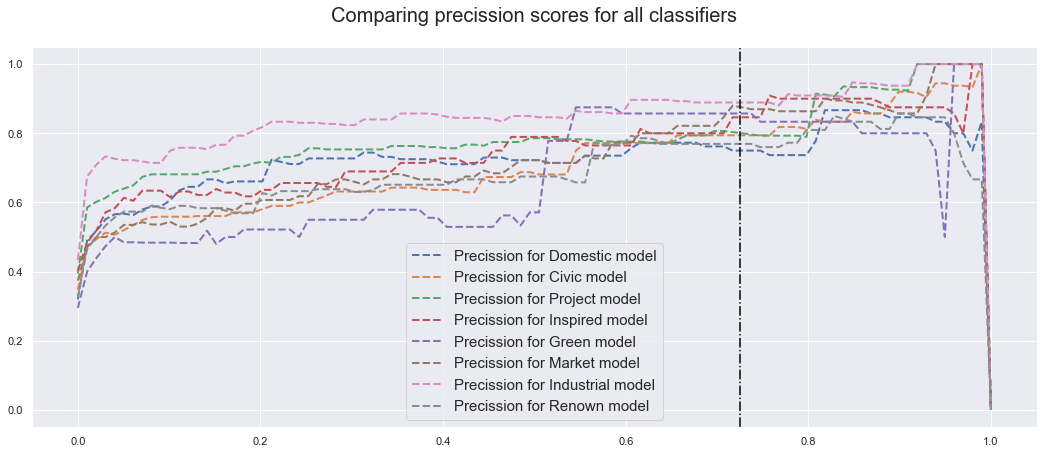

--training_Domestic.txt--
0.75
--training_Civic.txt--
0.7941176470588235
--training_Project.txt--
0.8
--training_Inspired.txt--
0.8461538461538461
--training_Green.txt--
0.8571428571428571
--training_Market.txt--
0.875
--training_Industrial.txt--
0.8888888888888888
--training_Renown.txt--
0.7692307692307693


In [116]:
plt.figure(figsize=(18,7))

equalized_conv_precissions_threshold=0.725
for k in _conventions_matches_precissions:
    x = thresholds
    y = _conventions_matches_precissions[k]
    
    plt.plot(x,y, marker='', linewidth=2, linestyle='dashed', label="toto")
    
plt.legend(["Precission for "+x.replace("training_", "").replace(".txt", "")+" model"
            for x in list(_conventions_matches_precissions.keys())], fontsize=15)

plt.title("Comparing precission scores for all classifiers", fontdict={'fontsize':20}, pad=25)
plt.axvline(x=equalized_conv_precissions_threshold, color='black', linestyle="-.")

plt.show()

for k in _conventions_matches_precissions:
    print("--{}--".format(k))
    print(_conventions_matches_precissions[k][int(equalized_conv_precissions_threshold*100)])



## Models evaluation on Github Sentences

In [106]:
github_sentences = {}

for i,x in enumerate(justif_files):
    texts = []
    
    data_train = pd.read_csv(os.path.join(BASE_DIR2,"training_"+x), sep='\t')
    conv = x.replace(".txt", "")
    github_sentences[conv] = data_train


In [107]:
github_sentences['Industrial'].head()

,category,text
0,1,"also, you can install drivers for various vm p..."
1,1,will return a bar plot comparing the models on...
2,1,* expected result: 2.63% test error rate with ...
3,1,"if you know your terminal size, you can contro..."
4,1,- to provide a range of non-functional feature...


In [108]:
thresholds = np.linspace(0,1,100)

_conventions_matches_github_precissions = {}


for k in _conventions_models.keys():
    
    tmp_precissions = []
    
    
    my_model = _conventions_models[k]
    
    conv = k.replace("training_", "").replace(".txt", "")
    data_train = github_sentences[conv]
    
    
    sequences = conventions_tokenizer.texts_to_sequences(data_train["text"].values)
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    
    my_data_x = data
    my_data_y = data_train["category"].values
    

    preds = my_model.predict(my_data_x)
    
    for t in thresholds:
        y_pred = get_positive_preds_with_threshold(preds,t)
        
        tmp_precissions.append(metrics.precision_score(my_data_y, y_pred))
        

    _conventions_matches_github_precissions[conv] = tmp_precissions

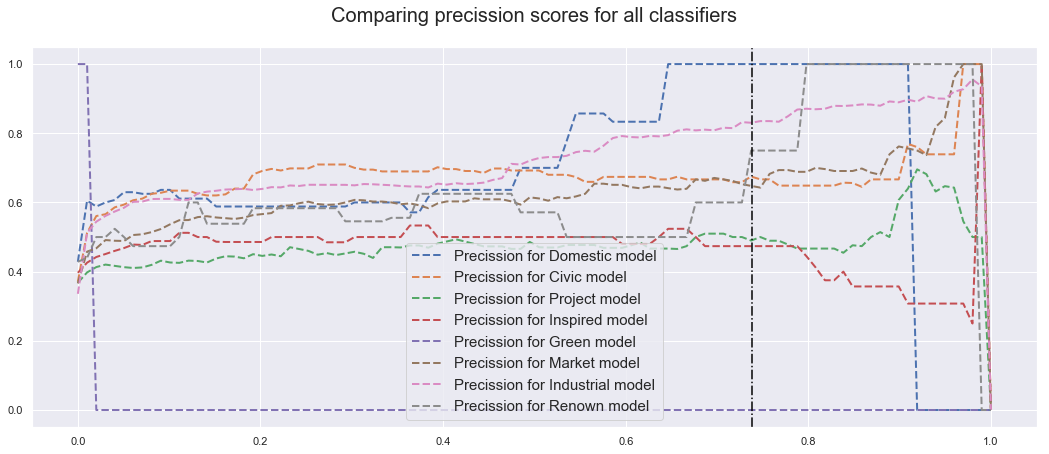

--Domestic--
1.0
--Civic--
0.675
--Project--
0.4897959183673469
--Inspired--
0.47368421052631576
--Green--
0.0
--Market--
0.647887323943662
--Industrial--
0.8303886925795053
--Renown--
0.75


In [113]:
plt.figure(figsize=(18,7))

equalized_conv_precissions_github_threshold=0.738
for k in _conventions_matches_github_precissions:
    x = thresholds
    y = _conventions_matches_github_precissions[k]
    
    plt.plot(x,y, marker='', linewidth=2, linestyle='dashed', label="toto")
    
plt.legend(["Precission for "+x.replace("training_", "").replace(".txt", "")+" model"
            for x in list(_conventions_matches_precissions.keys())], fontsize=15)

plt.title("Comparing precission scores for all classifiers", fontdict={'fontsize':20}, pad=25)
plt.axvline(x=equalized_conv_precissions_github_threshold, color='black', linestyle="-.")

plt.show()


for k in _conventions_matches_github_precissions:
    print("--{}--".format(k))
    print(_conventions_matches_github_precissions[k][int(equalized_conv_precissions_github_threshold*100)])